<h1 style="text-align:center;"><b>Laboratorio 2</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Daniel Machic (22118), Ariela Mishaan (22052)</h3>

**Github**: https://github.com/ArielaMishaanCohen/LAB2.git  

# Librerías

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread

## Task 1

**Cargar imagen en escala de grises**

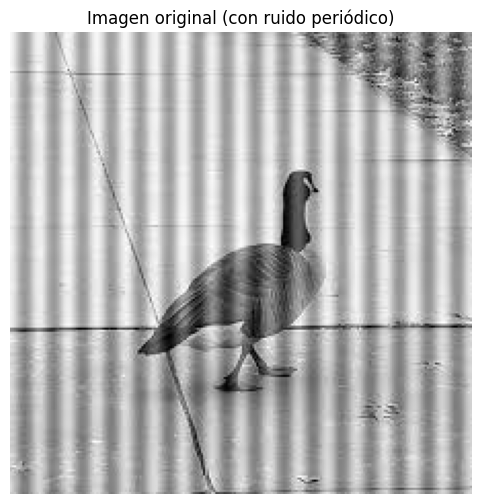

In [19]:
img = imread("periodic_noise.jpeg")

if img.ndim == 3:
    img = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2])

img = img.astype(np.float32)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title("Imagen original (con ruido periódico)")
plt.axis("off")
plt.show()


**DFT y Espectro de magnitud**

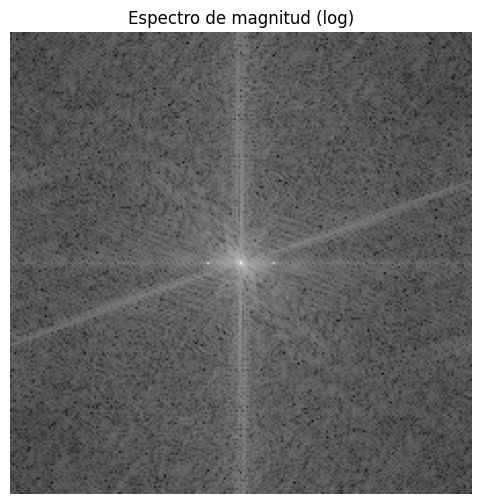

In [20]:
F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)

magnitude = np.abs(Fshift)
log_spectrum = np.log1p(magnitude)

plt.figure(figsize=(6,6))
plt.imshow(log_spectrum, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")
plt.show()


**Indentificación de picos del ruido**

Offsets detectados: [16, -16]


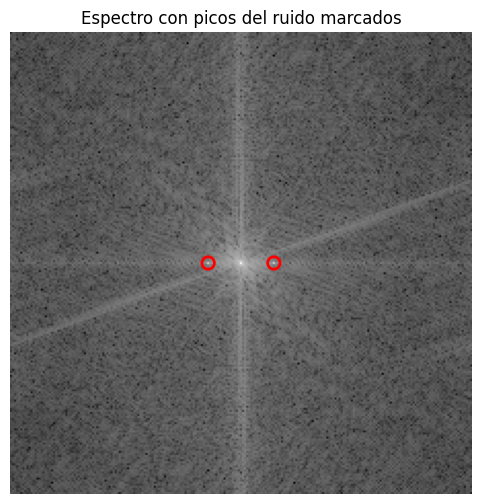

In [ ]:
h, w = log_spectrum.shape
cy, cx = h//2, w//2

row = log_spectrum[cy, :].copy()
dc_r = 6
row[cx-dc_r:cx+dc_r+1] = 0

# Picos más fuertes
top2 = np.argsort(row)[-2:]
top2 = top2[np.argsort(row[top2])[::-1]]

offsets = [int(x - cx) for x in top2]
print("Offsets detectados:", offsets)


plt.figure(figsize=(6,6))
plt.imshow(log_spectrum, cmap="gray")
for off in offsets:
    plt.scatter([cx + off], [cy], s=80, facecolors="none", edgecolors="r", linewidths=2)
plt.title("Espectro con picos del ruido marcados")
plt.axis("off")
plt.show()


**Máscara notch**

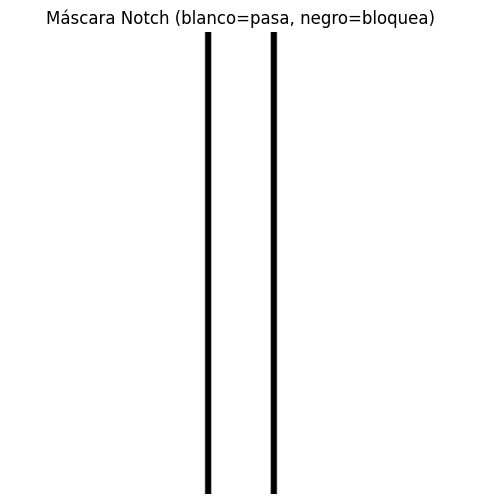

In [39]:
mask = np.ones((h, w), dtype=np.float32)

wx = 1          # ancho del notch
wy = h//2       # altura del notch 

for off in offsets:
    x0 = cx + off
    mask[cy-wy:cy+wy+1, x0-wx:x0+wx+1] = 0

Y, X = np.ogrid[:h, :w]
center_small = (Y-cy)**2 + (X-cx)**2 <= dc_r**2
mask[center_small] = 1

plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")
plt.title("Máscara Notch (blanco=pasa, negro=bloquea)")
plt.axis("off")
plt.show()


**Restaurar imagen**

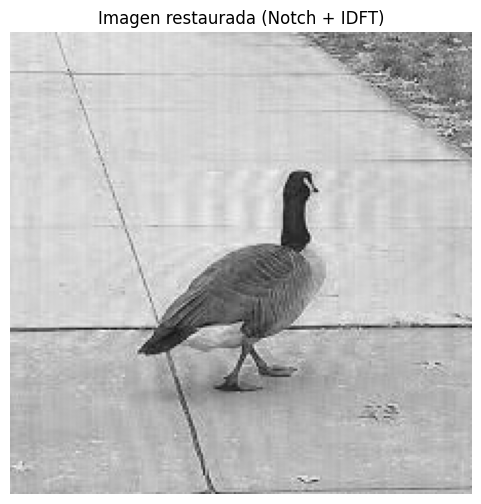

In [40]:
F_filt = Fshift * mask

img_back = np.real(np.fft.ifft2(np.fft.ifftshift(F_filt)))

plt.figure(figsize=(6,6))
plt.imshow(img_back, cmap="gray")
plt.title("Imagen restaurada (Notch + IDFT)")
plt.axis("off")
plt.show()


**Explicación**

Un filtro promedio en el dominio espacial suaviza toda la imagen por igual. Eso reduce las rayas, pero también borra bordes y texturas reales, porque elimina altas frecuencias útiles junto con el ruido. Sin embargo, el ruido periódico se muestra como picos específicos con Fourier. Un notch filter deja anular únicamente frecuencias extrañas y converva el resto de la información, manteniendo detalles nítidos. 

In [ ]:
# Fuente: https://www.geeksforgeeks.org/computer-vision/fast-fourier-transform-in-image-processing/ 
# Fuente:https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python

# Task 2